# ADA 442 – Bank Term Deposit Prediction

This notebook implements the steps required in the project specification (`file://ProjectADA442.pdf`) for the **Bank Marketing** dataset:

- Data cleaning and preprocessing
- Feature engineering / feature selection
- Model selection and comparison
- Hyperparameter tuning for the best model
- Saving the final trained pipeline to `final_model.pkl` for use in the Streamlit app (`app.py`).

Run the cells in order from top to bottom.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    f1_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid')

RANDOM_STATE = 42
N_JOBS = -1
TEST_SIZE = 0.2

file_path = Path('bank-additional.csv')
data = pd.read_csv(file_path, sep=';')

print('Shape:', data.shape)
data.head()


Shape: (4119, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

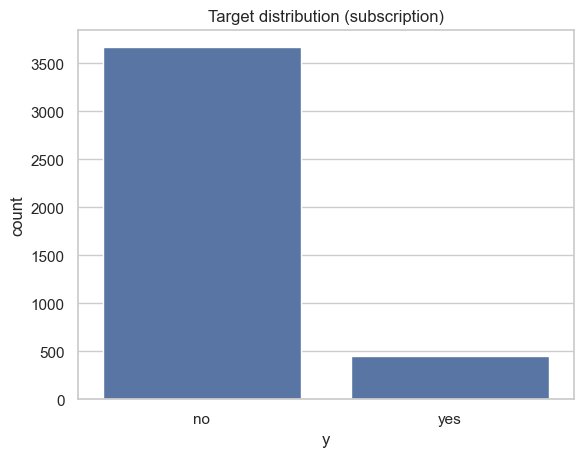

In [2]:
# Basic data info
print(data.info())

# Target variable distribution
print('\nTarget distribution (proportion):')
target_dist = data['y'].value_counts(normalize=True).rename('proportion')
print(target_dist)
print(f"\nPositive rate (yes): {target_dist.get('yes', 0):.3f}")

sns.countplot(data=data, x='y')
plt.title('Target distribution (subscription)')
plt.show()


In [3]:
# Separate features and target
X = data.drop(columns=['y'])
y = (data['y'] == 'yes').astype(int)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print('Categorical:', categorical_cols)
print('Numerical:', numerical_cols)

# Preprocess: impute, one-hot encode categoricals; impute + scale numericals
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols),
    ],
    remainder='drop'
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y,
)

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)


Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Numerical: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Train shape: (3295, 20)
Test shape: (824, 20)


In [4]:
# Define three candidate models inside pipelines (stronger defaults for imbalance and stability)
log_reg = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(
        max_iter=2000,
        class_weight='balanced',
        n_jobs=N_JOBS,
        C=1.0,
        penalty='l2',
        solver='lbfgs',
    )),
])

rf_clf = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced_subsample',
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
    )),
])

gb_clf = Pipeline([
    ('preprocess', preprocessor),
    ('clf', GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.9,
        random_state=RANDOM_STATE,
    )),
])

models = {
    'LogisticRegression': log_reg,
    'RandomForest': rf_clf,
    'GradientBoosting': gb_clf,
}


def evaluate_model(name: str, model: Pipeline) -> dict:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    print(f"\n{name}")
    print(f"Accuracy: {acc:.3f}")
    print(f"F1: {f1:.3f}")
    print(f"ROC-AUC: {auc:.3f}")
    return {'model': name, 'accuracy': acc, 'f1': f1, 'roc_auc': auc}


results = [evaluate_model(name, model) for name, model in models.items()]
results_df = pd.DataFrame(results)
results_df.sort_values(by='roc_auc', ascending=False)



LogisticRegression
Accuracy: 0.875
F1: 0.593
ROC-AUC: 0.942

RandomForest
Accuracy: 0.907
F1: 0.353
ROC-AUC: 0.942

GradientBoosting
Accuracy: 0.910
F1: 0.526
ROC-AUC: 0.945


,model,accuracy,f1,roc_auc
2,GradientBoosting,0.910194,0.525641,0.944687
1,RandomForest,0.906553,0.352941,0.942348
0,LogisticRegression,0.875000,0.592885,0.942295


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 150, 'clf__subsample': 0.8}
Best CV ROC-AUC: 0.9351119314745567

Classification report (test):
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       734
           1       0.63      0.48      0.54        90

    accuracy                           0.91       824
   macro avg       0.79      0.72      0.75       824
weighted avg       0.90      0.91      0.91       824

Test ROC-AUC: 0.9481531940660006


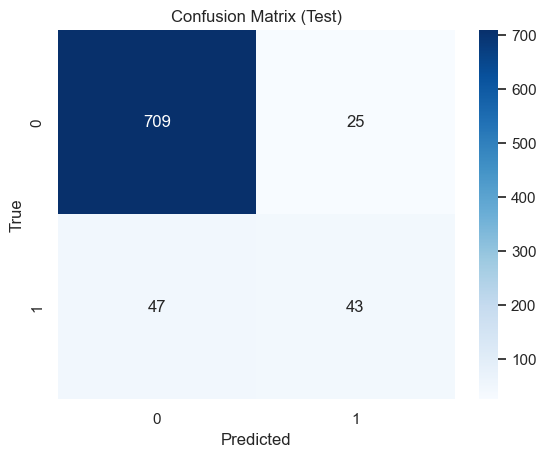

In [5]:
# Hyperparameter tuning for the strongest baseline (GradientBoosting) using stratified CV

gb_grid = Pipeline([
    ('preprocess', preprocessor),
    ('clf', GradientBoostingClassifier(random_state=RANDOM_STATE)),
])

param_grid = {
    'clf__n_estimators': [150, 250, 350],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': [2, 3],
    'clf__subsample': [0.8, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_search = GridSearchCV(
    gb_grid,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=N_JOBS,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print('Best params:', grid_search.best_params_)
print('Best CV ROC-AUC:', grid_search.best_score_)

best_model = grid_search.best_estimator_

# Evaluation on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print('\nClassification report (test):')
print(classification_report(y_test, y_pred))

print('Test ROC-AUC:', roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test)')
plt.show()


In [6]:
# Save the final model pipeline for use in Streamlit app

output_path = 'final_model.pkl'
joblib.dump(best_model, output_path)
print(f'Saved final model pipeline to {output_path}')


Saved final model pipeline to final_model.pkl
